In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset
import itertools
from datasets import load_dataset
from sentence_transformers import SentenceTransformer , SentenceTransformerTrainer
from sentence_transformers.losses import CachedMultipleNegativesRankingLoss ,ContrastiveLoss, OnlineContrastiveLoss
import os
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
import torch

In [2]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score

def evaluate(y_true ,y_pred ): 
    # Calculate basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)#, average='weighted'
    precision = precision_score(y_true, y_pred)#, average='weighted'
    recall = recall_score(y_true, y_pred)#, average='weighted'

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    # Calculate specificity (True Negative Rate)
    specificity = TN / (TN + FP)

    # Calculate NPV (Negative Predictive Value)
    NPV = TN / (TN + FN)

    auc = roc_auc_score(y_true, y_pred)

    results = {
        "F1 score": f1,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "AUC": auc,
        "Specificity": specificity,
        # "NPV": NPV
    }
    return results


In [3]:
print("Imports completed")

os.environ["WANDB_DISABLED"] = "true"

df0 = pd.read_csv("/home/u111169/wrkdir/mgh-project/ChemAP/dataset/DrugApp/All_training_feature_vectors.csv")
df=df0[["SMILES",	"Label"]]

print("dataset created ")

from sklearn.model_selection import train_test_split
test_size = 0.2
# val_size = 0.5
train_df , test_df = train_test_split(df , stratify = df.Label , test_size = test_size , random_state=1234)

print("train test done!")

Imports completed
dataset created 
train test done!


In [25]:
a = [len(s) for s in df["SMILES"]]

In [28]:
l = [] 
for i in a : 
    if i > 150: 
        l.append(i)

In [29]:
len(l)/len(a)

0.08167841127482384

(array([2.878e+03, 1.820e+02, 2.900e+01, 1.600e+01, 9.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([   7. ,  155.3,  303.6,  451.9,  600.2,  748.5,  896.8, 1045.1,
        1193.4, 1341.7, 1490. ]),
 <BarContainer object of 10 artists>)

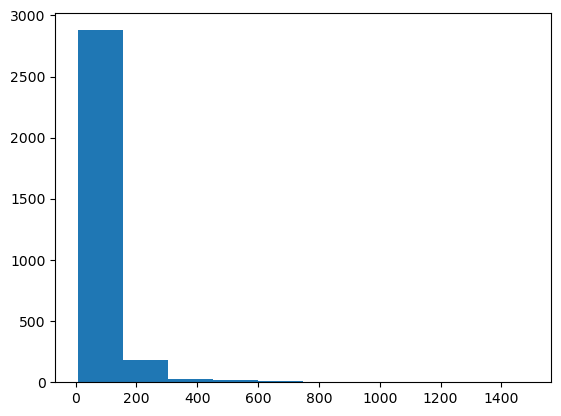

In [32]:
import matplotlib.pyplot as plt

plt.hist(a)

# Training the sentence transformers

In [31]:
# test_df , val_df = train_test_split(temp , stratify = temp.Label , test_size = val_size , random_state=1234)
#-----------------------------------
# reset index
train_df.reset_index(drop=True, inplace=True)
# val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

def duable_maker_with_label(df):
    pos_df = df[df["Label"]==0]["SMILES"]
    neg_df = df[df["Label"]==1]["SMILES"]
    elements = pos_df.tolist()
    elements_neg = neg_df.tolist()
    tuple_length = 2
    unique_tuples = list(itertools.combinations(elements, tuple_length))
    unique_tuples_neg = list(itertools.combinations(elements_neg, tuple_length))
    ll = unique_tuples + unique_tuples_neg
    df1 = pd.DataFrame(unique_tuples, columns=['Column1', 'Column2'])
    df2 = pd.DataFrame(unique_tuples, columns=['Column1', 'Column2'])
    combined_df = pd.concat([df1, df2], ignore_index=True)
    combined_df["label"]=1
    unique_tuples = set(itertools.product(elements, elements_neg))
    unique_tuples_list = list(unique_tuples)
    df3 = pd.DataFrame(unique_tuples_list, columns=['Column1', 'Column2'])
    df3["label"]=0
    combined_df_f = pd.concat([combined_df, df3], ignore_index=True)
    return combined_df_f

df_embed_d = duable_maker_with_label(train_df)
train_df_d , val_df_d = train_test_split(df_embed_d , stratify = df_embed_d.label , test_size = 0.2 , random_state=1234)
train_df_d.reset_index(drop=True, inplace=True)
val_df_d.reset_index(drop=True, inplace=True)
train_dataset = Dataset.from_pandas(train_df_d)
val_dataset = Dataset.from_pandas(val_df_d)

print("datasets are doubled and are ready for training")

# Load a model to train/finetune
model = SentenceTransformer("/home/u111169/wrkdir/mgh-project/models/models--DeepChem--ChemBERTa-77m-MTR/snapshots/66b895cab8adebea0cb59a8effa66b2020f204ca") # "Muennighoff/SGPT-125M-weightedmean-nli-bitfit" "microsoft/mpnet-base"
print("Max Sequence Length:", model.max_seq_length)

loss = OnlineContrastiveLoss(model)

args = SentenceTransformerTrainingArguments(
    output_dir='/home/u111169/wrkdir/mgh-project/checkpoints',
    seed = 42 ,
    data_seed = 42,
    do_eval=True,
    do_train=True,
    num_train_epochs= 10,
    per_device_train_batch_size=64,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=128,
    gradient_checkpointing=True ,
    eval_accumulation_steps= 1,
    eval_strategy = "steps",
    #drop_last=False,
    eval_steps=400,
    eval_on_start= False,
    weight_decay=0.01,
    learning_rate=2e-3,
    lr_scheduler_type='cosine',
    warmup_steps=100,
    logging_strategy = "steps",
    logging_steps= 200 ,
    save_strategy='steps',
    save_total_limit = 4,
    save_safetensors = False ,
    #torch_empty_cache_steps= 60,
    torchdynamo= "eager" ,
    torch_compile= True,
)

No sentence-transformers model found with name /home/u111169/wrkdir/mgh-project/models/models--DeepChem--ChemBERTa-77m-MTR/snapshots/66b895cab8adebea0cb59a8effa66b2020f204ca. Creating a new one with mean pooling.
Some weights of RobertaModel were not initialized from the model checkpoint at /home/u111169/wrkdir/mgh-project/models/models--DeepChem--ChemBERTa-77m-MTR/snapshots/66b895cab8adebea0cb59a8effa66b2020f204ca and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/u111169/.local/lib/python3.10/site-packages/transformers/training_args.py:1696: FutureWarning: `torchdynamo` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `torch_compile_backend` instead
  warnings.warn(
The speedups for torchdynamo mostly come wih GPU Ampere or higher and which is not detected here.
Using the `WANDB_DISABLED` environment variable is

datasets are doubled and are ready for training
Max Sequence Length: 512


In [32]:
trainer = SentenceTransformerTrainer(
    model=model,
    args = args ,
    train_dataset=train_dataset,
    eval_dataset= val_dataset,
    loss = loss
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Detected kernel version 5.3.18, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
200,2.863900,2.862875


# sentence transformers inference

In [4]:
model = SentenceTransformer("/home/u111169/wrkdir/mgh-project/arxive/checkpoints-arxive/chemberta_sentence_transformers/checkpoint-57000") # "Muennighoff/SGPT-125M-weightedmean-nli-bitfit" "microsoft/mpnet-base"


/share/apps/eb/Anaconda3/2023.03-1/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
test_not = test_df[test_df["Label"]==0]["SMILES"].tolist()
test_app = test_df[test_df["Label"]==1]["SMILES"].tolist()


train_label = train_df["Label"].tolist()
test_label = test_df["Label"].tolist()

train_list =train_df["SMILES"].tolist()
test_list =test_df["SMILES"].tolist()

In [5]:
external_d = [
    "Ogsiveo",
    "Agamree",
    "Velsipity",
    "Exxua",
    "Litfulo",
    "Miebo",
    "Veozah",
    "Daybue",
    "Zavzpret",
    "Filspari",
    "Orserdu",
    "Fabhalta",
    "Truqap",
    "Augtyro",
    "Vanflyta",
    "Posluma",
    "Paxlovid",
    "Joenja",
    "Skyclarys",
    "Jaypirca",
    "Lufotrelvir",
    "Zandelisib",
    "Alpelisib",
    "AMG 337",
    "Evobrutinib",
    "Linperlisib",
    "H3B-8800",
    "Gamcemetinib"
]


In [43]:
ex_df = pd.read_csv("/home/u111169/wrkdir/mgh-project/ChemAP/dataset/processed_data/External/External.csv")
ex_df["Drug Name"][0]="Fabhalta"

filtered_df = ex_df[ex_df['Drug Name'].isin(external_d)].reset_index(drop=True)

filtered_df.to_csv("filtered_ex.csv" , index=False)

ex = filtered_df["SMILES"].tolist()
ex_label = filtered_df["Approval"].tolist()

In [37]:
import torch

from sentence_transformers import SentenceTransformer

corpus = train_list
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)

In [45]:
embed_test = model.encode(ex, convert_to_tensor=False)#.numpy()

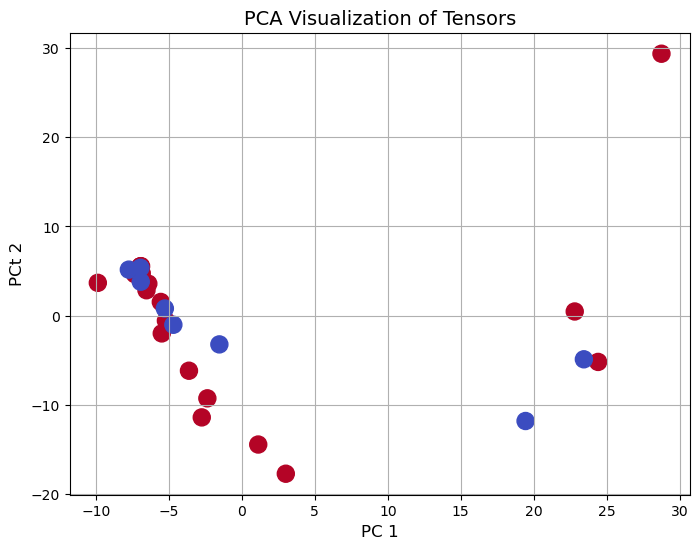

In [47]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


tensors = embed_test#corpus_embeddings.numpy()
labels = np.array(ex_label)#test_label

scaler = StandardScaler()
tensors_scaled = scaler.fit_transform(tensors)


pca = PCA(n_components=2)
principal_components = pca.fit_transform(tensors_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], 
           c=labels, cmap='coolwarm', s=150, alpha=1, edgecolor='face')  # Add alpha=0.5 for transparency
plt.title('PCA Visualization of Tensors', fontsize=14)
plt.xlabel('PC 1', fontsize=12)
plt.ylabel('PCt 2', fontsize=12)
plt.grid(True)
plt.show()

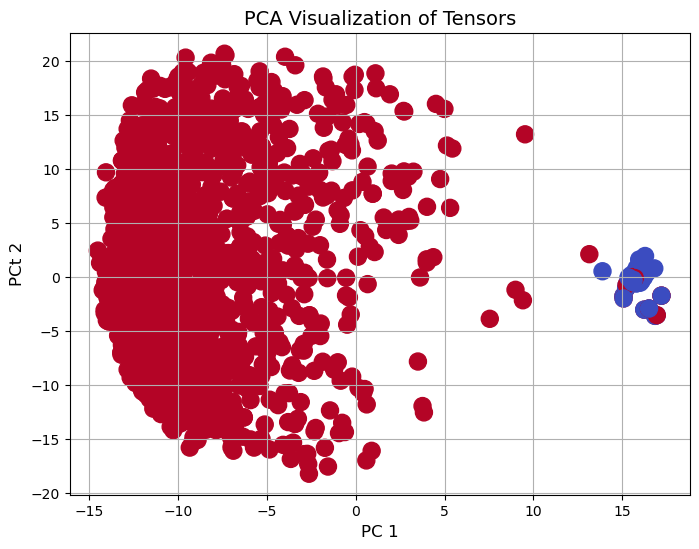

In [59]:
tensors = corpus_embeddings.cpu().numpy()
labels = np.array(train_label)#test_label

scaler = StandardScaler()
tensors_scaled = scaler.fit_transform(tensors)


pca = PCA(n_components=2)
principal_components = pca.fit_transform(tensors_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], 
           c=labels, cmap='coolwarm', s=150, alpha=1, edgecolor='face')  # Add alpha=0.5 for transparency
plt.title('PCA Visualization of Tensors', fontsize=14)
plt.xlabel('PC 1', fontsize=12)
plt.ylabel('PCt 2', fontsize=12)
plt.grid(True)
plt.show()

In [76]:
# Import required libraries
import numpy as np
import torch
from sklearn.tree import DecisionTreeClassifier

tensors = corpus_embeddings#.numpy()
labels =torch.tensor(train_label)# np.array(train_label)

# cls = DecisionTreeClassifier(
#     max_depth=10000,  # Maximum depth of the tree
#     random_state=42  # For reproducibility
# )


# cls.fit(tensors, labels)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Assuming your tensors and labels are already in numpy format
# Convert numpy arrays to PyTorch tensors
X_train =tensors# torch.from_numpy(tensors).float()
y_train =labels# torch.from_numpy(labels).long()

# Create a custom dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.len

# Create dataset and dataloader
train_dataset = TextDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the deep MLP
class DeepMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DeepMLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        #self.bn1 = nn.BatchNorm1d(512)
        
        self.layer2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        #self.bn2 = nn.BatchNorm1d(512)
        
        self.layer3 = nn.Linear(512, 512)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)
        #self.bn3 = nn.BatchNorm1d(512)
        
        self.layer4 = nn.Linear(512, output_dim)
    
    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.dropout1(x)
        #x = self.bn1(x)
        
        x = self.relu2(self.layer2(x))
        x = self.dropout2(x)
       # x = self.bn2(x)
        
        x = self.relu3(self.layer3(x))
        x = self.dropout3(x)
        #x = self.bn3(x)
        
        x = self.layer4(x)
        return x

# Initialize the model
input_dim = tensors.shape[1]
output_dim = len(np.unique(labels))  # For classification
model = DeepMLP(input_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    # Print statistics
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [10/100], Loss: 0.0
Epoch [20/100], Loss: 0.0
Epoch [30/100], Loss: 0.0
Epoch [40/100], Loss: 0.0
Epoch [50/100], Loss: 0.0
Epoch [60/100], Loss: 0.0
Epoch [70/100], Loss: 0.0
Epoch [80/100], Loss: 0.0
Epoch [90/100], Loss: 0.0
Epoch [100/100], Loss: 0.0


In [80]:
# Example evaluation (assuming you have a validation set)
# Convert validation data to PyTorch tensors
X_val = torch.from_numpy(embed_test).float()
y_val = torch.tensor(test_df["Label"].tolist()).long()
valid_dataset = TextDataset(X_val, y_val)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

model.eval()
y_pred = []
total_correct = 0
total_incorrect = 0

with torch.no_grad():
    for inputs, labels in valid_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(predicted)):
            actual_label = labels[i].item()
            predicted_label = predicted[i].item()
            y_pred.append(predicted_label)
            if predicted_label == actual_label:
                total_correct += 1
            else:
                total_incorrect += 1

# Now you have:
# - correct_examples: List of dictionaries containing the input, actual label, and predicted label for correct predictions.
# - incorrect_examples: List of dictionaries containing the input, actual label, and predicted label for incorrect predictions.

print(f"Total correct examples: {total_correct}")
print(f"Total incorrect examples: {total_incorrect}")

Total correct examples: 438
Total incorrect examples: 187


In [57]:
y_pred = cls.predict(embed_test)
    

In [60]:
top_k = min(10, len(corpus))
F_result = []

for query in ex: 
    query_embedding = model.encode(query, convert_to_tensor=True)
    similarity_scores = model.similarity(query_embedding, corpus_embeddings)[0]
    scores, indices = torch.topk(similarity_scores, k=top_k)
    L = []
    for indx in indices: 
        L.append(train_df[train_df["SMILES"]==corpus[indx]]["Label"].tolist()[0])
        count_of_ones = L.count(1)
    if count_of_ones > len(L) / 2:
        F_result.append(1)
    else: 
        F_result.append(0)

In [49]:
test_label =test_df["Label"].tolist()

In [61]:
F_result,ex_label

([0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])

In [62]:
evaluate(ex_label ,F_result)

{'F1 score': 0.24,
 'Accuracy': 0.32142857142857145,
 'Precision': 0.6,
 'Recall': 0.15,
 'AUC': 0.44999999999999996,
 'Specificity': 0.75}

# Chemberta

In [4]:
# Imports
import pandas as pd
from datasets import load_dataset , Dataset
from transformers import RobertaTokenizer , RobertaForSequenceClassification , TrainingArguments , Trainer,TrainerCallback,AutoModelForSequenceClassification,AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support , accuracy_score
import torch
import numpy as np
import torch.nn as nn
import numpy as np
from datasets import Dataset, Features, Value,Sequence

In [5]:
df.rename(columns={"Label":"labels"}, inplace=True)

test_size = 0.2
val_size = 0.5
train_df , temp = train_test_split(df , stratify = df.labels , test_size = test_size , random_state=1234)
test_df , val_df = train_test_split(temp , stratify = temp.labels , test_size = val_size , random_state=1234)
#-----------------------------------
# reset index
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_7793/3336064996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"Label":"labels"}, inplace=True)


In [65]:

#-----------------------------------
# convert the dataframes to huggingface dataset for easier upload on hub and eaiser accessibility
dataset_train = Dataset.from_pandas(train_df)
dataset_df = Dataset.from_pandas(val_df)
dataset_test = Dataset.from_pandas(test_df)
dataset_ex = Dataset.from_pandas(filtered_df)

#tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")#'FacebookAI/xlm-roberta-large'
tokenizer = RobertaTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")#'FacebookAI/xlm-roberta-large'


def tokenize_function(examples):
    return tokenizer(examples['SMILES'], padding="max_length" , truncation=True )#,max_length=166

tokenized_train = dataset_train.map(tokenize_function)
tokenized_val = dataset_df.map(tokenize_function)
tokenized_test = dataset_test.map(tokenize_function)
tokenized_ex = dataset_ex.map(tokenize_function)

Map:   0%|          | 0/2497 [00:00<?, ? examples/s]

Map:   0%|          | 0/313 [00:00<?, ? examples/s]

Map:   0%|          | 0/312 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor([len(train_df[train_df["labels"] == i]) / len(train_df) for i in np.unique(train_df["labels"])]).to(device)
#class_weights = torch.tensor([0.25,0.25,0.25,0.25]).to(device)

class CustomLoss(nn.Module):
    def __init__(self, class_weights):
        super(CustomLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, logits, labels):
        ce_loss = self.ce_loss(logits, labels)
        l1_loss = torch.mean(torch.abs(logits))
        return ce_loss + 0.01 * l1_loss

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = CustomLoss(class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [17]:
model_name ="DeepChem/ChemBERTa-77M-MTR"# "FacebookAI/xlm-roberta-large""google-bert/bert-base-uncased"
import os
os.environ["WANDB_DISABLED"] = "true"
model = RobertaForSequenceClassification.from_pretrained("/home/u111169/.cache/huggingface/hub/models--DeepChem--ChemBERTa-77M-MTR/snapshots/66b895cab8adebea0cb59a8effa66b2020f204ca" ,num_labels=2)
model.config.classifier_dropout=0.01

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /home/u111169/.cache/huggingface/hub/models--DeepChem--ChemBERTa-77M-MTR/snapshots/66b895cab8adebea0cb59a8effa66b2020f204ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import EarlyStoppingCallback
training_args = TrainingArguments(
    output_dir='/home/u111169/wrkdir/mgh-project/checkpoints/fine_tuning_chemberta_classic_way',
    num_train_epochs= 5,
    evaluation_strategy='steps',
    save_strategy='steps',
    learning_rate=2e-3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    eval_steps=20,
    #save_total_limit=3,
    gradient_accumulation_steps=1,
    eval_accumulation_steps=1,
    do_eval=True,
    do_train=True,
    weight_decay=0.1,
    logging_dir = "logs",
    logging_strategy="steps",
    logging_steps = 10,
    dataloader_drop_last=True,
    save_safetensors=False,
    adam_epsilon=1e-08,
    warmup_steps=100,
    seed=42,
    lr_scheduler_type='cosine',
    load_best_model_at_end = True,
    label_smoothing_factor=0.01,
)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer = tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]

)
trainer.train()

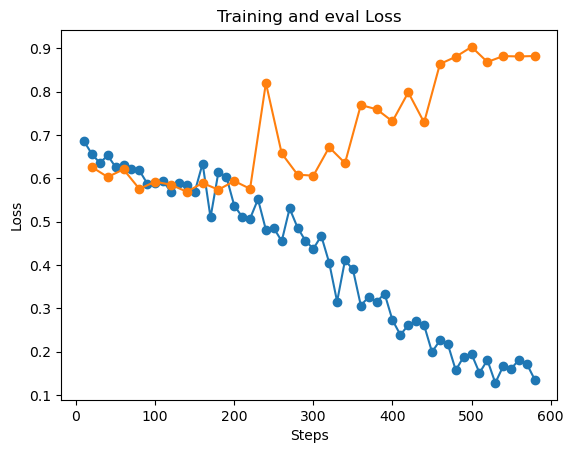

In [1]:
# Drawing the loss plot

import json
import matplotlib.pyplot as plt

# Step 1: Open and load the JSON file
with open("/home/u111169/wrkdir/mgh-project/arxive/checkpoints-arxive/fine_tuning_chemberta_classic_way/trainer-not-custom/checkpoint-585/trainer_state.json", "r") as json_file:
    json_data = json.load(json_file)

data = json_data["log_history"]



# Extract steps and losses from the data
steps = [entry["step"] for entry in data if "step" in entry and "loss" in entry]
steps_ev = [step for step in steps if step % 20 == 0]
losses_t = [entry["loss"] for entry in data if "step" in entry and "loss" in entry]
losses_e = [entry["eval_loss"] for entry in data if "step" in entry and "eval_loss" in entry]
# Create a line plot
plt.plot(steps, losses_t, marker="o")
plt.plot(steps_ev, losses_e, marker="o")

# Set labels and title
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and eval Loss")

plt.savefig("plot.png", bbox_inches="tight")
# Display the plot
plt.show()

In [67]:
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("/home/u111169/wrkdir/mgh-project/arxive/checkpoints-arxive/fine_tuning_chemberta_classic_way/trainer-not-custom/checkpoint-585" ,num_labels=2)
model.to(device)
model.eval()

def preprocess_and_predict(examples):
    inputs = tokenizer(examples['SMILES'], return_tensors='pt', padding=True, truncation = True)
    inputs = inputs.to(device)
    outputs = model(**inputs)
    predicted_class_idx = torch.argmax(outputs.logits)
    predicted_class_prob = torch.nn.functional.softmax(outputs.logits, dim=1)[0][predicted_class_idx]
    predicted_class_idx = predicted_class_idx.cpu()  # Move tensors to CPU
    predicted_class_prob = predicted_class_prob.cpu()
    return {
        'predicted_class': predicted_class_idx,
        'predicted_class_prob': predicted_class_prob
    }

test = tokenized_ex.map(preprocess_and_predict, batch_size=8 , writer_batch_size=8)
results_df = test.to_pandas()
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,roc_auc_score

y_true = results_df['Approval'].tolist()
y_pred = results_df['predicted_class'].tolist()


Map:   0%|          | 0/28 [00:00<?, ? examples/s]

In [68]:
evaluate(y_true ,y_pred )

{'F1 score': 0.6666666666666667,
 'Accuracy': 0.6071428571428571,
 'Precision': 0.8461538461538461,
 'Recall': 0.55,
 'AUC': 0.65,
 'Specificity': 0.75}

In [69]:
(y_true ,y_pred )

([1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1])

# XGBoost

In [11]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import RDKFingerprint
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

In [12]:
def maccs(smile):
    mol = Chem.MolFromSmiles(smile)
    fp = AllChem.GetMACCSKeysFingerprint(mol)
    maccs_keys = fp.ToBitString()
    return maccs_keys
df["MACCS"] = df["SMILES"].map(maccs)
df=df[["MACCS" , "labels"]]

/tmp/ipykernel_7793/3441131338.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MACCS"] = df["SMILES"].map(maccs)


In [15]:
# train_df["MACCS"] = train_df["SMILES"].map(maccs)
# test_df["MACCS"] = test_df["SMILES"].map(maccs)

In [16]:
# def converter(df):
#     ll  = []
#     for i in df["MACCS"].tolist():
#         ll.append(i)
#     X_arr = np.array(ll)
#     return X_arr

# X_arr = converter(train_df)
# y_arr = np.array(train_df["labels"])

# X_arr_v = converter(test_df)
# y_arr_v= np.array(test_df["labels"])

In [17]:
# from xgboost import XGBClassifier

# bst = XGBClassifier(
#     max_depth=30,
#     n_estimators=500,
#     learning_rate=0.05,      # Lower learning rate for better convergence
#     min_child_weight=1,
#     gamma=0,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_alpha=0.1,           # L1 regularization
#     reg_lambda=1              # L2 regularization
# )
# # fit model
# bst.fit(X_arr, y_arr)

ModuleNotFoundError: No module named 'xgboost'